In [204]:
import warnings
warnings.filterwarnings('ignore')

# Load NeuroKit and other useful packages
import os
from copy import deepcopy
#!pip install neurokit2
import neurokit2 as nk
import numpy as np
import pandas as pd
import scipy.stats as st
import scipy.signal as signal
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]  # Bigger images

# Load lists
from lists import dyads, num_dyads, participants, num_participants

conditions = ["sit","gaze","gaze_swap","sync"]

In [205]:
# Cosine interpolation
def cosine(x, x1, x2):
    """Returns cosine value (y) for given time step (x) in one period (T) based on the interval between x1 and x2.

    Args:
        x (float): time step
        x1 (float): period start (y=1)
        x2 (float): period end (y=1)

    Returns:
        val (float): cosine value
    """
    from math import cos, pi
    T = x2-x1
    val = 0.5 * cos(2.0 * pi * (x - x1) / T)
    return val

def rpeaks_cosine_interpolation(rpeaks_idx, length):
    """Returns cosine interpolation with varying frequency for successive events (rpeaks_idx) in a time series.

    Args:
        rpeaks_idx (array): index of r-peaks in the time series
        length (int): length of the time series

    Returns:
        rpeaks_cip : cosine interpolation of rpeaks
    """
    num_rpeaks = len(rpeaks_idx)
    
    # Interpolation
    rpeaks_cip = [np.nan]*(rpeaks_idx[0])

    for i in range(num_rpeaks):
        if i == num_rpeaks-1:
            break
        x1 = rpeaks_idx[i]
        x2 = rpeaks_idx[i+1]
        T = x2-x1
        f = lambda x: cosine(x, x1, x2)
        # span interval with corresponding number of time steps + noise
        x = np.linspace(x1, x2, T)
        y = [f(x) for x in x]
        rpeaks_cip = rpeaks_cip + y

    rpeaks_cip = rpeaks_cip + [np.nan]*(length-rpeaks_idx[-1])
    # keep in mind: there are nans at the start and end

    return rpeaks_cip

In [206]:
# Make some noise
# discrete normal distribution

def make_noise(rpeaks_idx, noise_spread=10):
    """Generates n = rpeaks_idx discrete normal distribution with a sum of 0 and a standard deviation of noise_spread.\n
        As there is no deterministic way to determine these values a while-loop is incoorperated. 
        The higher noise_spread, the more time it takes.\n
        Returns a nested list with n numbers of noise and percentage of noise based on the mean IBI value.

    Args:
        rpeaks_idx (array): n & mean IBI
        noise_spread (int, optional): standard deviation of noise. Defaults to 10.

    Returns:
        [noise, noise_percentage] : nested list
    """
    num_rpeaks = len(rpeaks_idx)
    noise_size = num_rpeaks-2
    # num_rpeaks-2, 
    # because the first r-peak index does not represent an IBI
    # and the noise should end at the last original IBI

    noise = np.round(
        np.random.normal(
            scale=noise_spread, 
            size=noise_size))
    # Search for sum = 0
    while sum(noise) != 0 or np.round(np.std(noise), 1) != noise_spread:
        noise = np.round(
            np.random.normal(
                scale=noise_spread, 
                size=noise_size))
    # Convert to ints
    noise = [round(x) for x in noise]
    noise.insert(0, 0)
    noise.append(0)
    
    # Calculate average noise (%)
    # Get IBI
    ibi = [
        rpeaks_idx[s]-rpeaks_idx[s-1]
        for s in range(num_rpeaks)
        if s > 0
    ]
    
    ibi_mean = np.mean(np.array(ibi))
    noise_percentage = np.mean(abs(np.array(noise)))/ibi_mean*100
    noise_percentage = np.round(noise_percentage, 2)
    
    return [noise, noise_percentage]

# Preprocess data

In [207]:
sampling_rate = 2000
length = 5*60*sampling_rate

ecg_raw = {}
ecg = {}
rpeaks = {}
rpeaks_idx = {}
noise = []
con = "gaze"

In [208]:
# Load data: raw ecgs for 300 s at 2000 Hz
ecg_raw[con] = np.load(f"data/ecg_raw/ecg_raw_{con}.npy")

# Clean and normalize data
ecg[con] = [
    nk.ecg_clean(
        ecg_raw[con][i], 
        sampling_rate=sampling_rate, 
        method="neurokit")
    for i in participants
]
# Get R-peaks as a binary time series
rpeaks[con] = [
    nk.ecg_peaks(
        ecg[con][i], 
        sampling_rate=sampling_rate
        )[0]["ECG_R_Peaks"]
    for i in participants
]
rpeaks_idx[con] = [
    [
        s for s, 
        x in enumerate(rpeaks[con][i]) 
        if x == 1
    ]
    for i in participants
]
noise = [
    # returns 2 vaules in a nested list: noise[:] & noisepercentage[-1]
    make_noise(rpeaks_idx[con][i],noise_spread=0)
    for i in participants
]

In [209]:
# Create SYNC with GAZE+noise
rpeaks_idx["sync_temp"] = [
    np.array(rpeaks_idx["gaze"][i])+(noise[i][0])
    for i in participants
]

# Create list for indices with partners that did not
# take part in the experiment together
# with an equal gender distribution, e.g.:
# 0 1 2 3 4 5 6 7
# ->
# 0 3 4 7
sync_idx = sorted(
    [*participants[::4],
     *participants[3::4]])

rpeaks_idx["sync"] = [None]*(len(participants))
rpeaks_idx["sync"][::2] = [
    rpeaks_idx["gaze"][idx]
    for _, idx in enumerate(sync_idx)
]
rpeaks_idx["sync"][1::2] = [
    rpeaks_idx["sync_temp"][idx]
    for _, idx in enumerate(sync_idx)
]

del rpeaks_idx["sync_temp"]

# Add lag
lag = 1*sampling_rate
rpeaks_idx["sync"][1::2] = [
    rpeaks_idx["sync"][i]+np.array(lag)
    for i in participants
    if i % 2 == 1
]

In [210]:
length = len(rpeaks["gaze"][0])

data_simul_temp = {}
for con in ["gaze","sync"]:
    if con == "sync":
        data_simul_temp[con] = [
        rpeaks_cosine_interpolation(
            rpeaks_idx[con][i], 
            length+lag) # add lag to length of time series
        for i in participants
    ]
    else:
        data_simul_temp[con] = [
            rpeaks_cosine_interpolation(
                rpeaks_idx[con][i], 
                length)
            for i in participants
        ]
    
data_simul_temp["sync"][::2] = [
    data_simul_temp["sync"][i][:-lag]
    for i in participants
    if i % 2 == 0
]

data_simul_temp["sync"][1::2] = [
    data_simul_temp["sync"][i][:-lag]
    for i in participants
    if i % 2 == 1
]

(0.0, 9000.0)

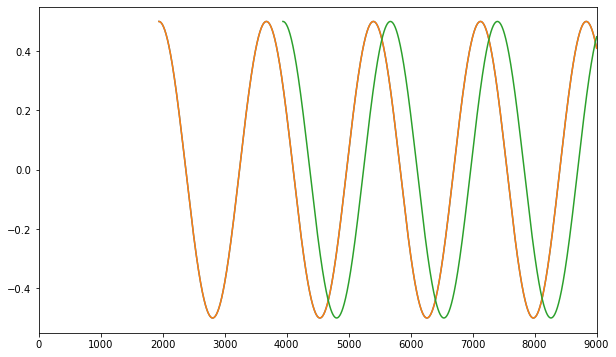

In [211]:
plt.plot(data_simul_temp["gaze"][0])
plt.plot(data_simul_temp["sync"][0])
plt.plot(data_simul_temp["sync"][1])
plt.xlim(0,9000)

In [212]:
# Show noise percentage
noise_added = [
    noise[idx][1]
    for idx in sync_idx
]

print(
    f"Noise added:{noise_added} %\
    \nMean: {np.mean(noise_added):.2f} %\
    \nSD: {np.std(noise_added):.2f}")

Noise added:[0.0, 0.0, 0.0, 0.0] %    
Mean: 0.00 %    
SD: 0.00


In [213]:
# at the end
data_trim = {}
data_down = {}
data_lag = {}
data_lag["sync"] = [None]*(num_participants)
data_fin = {}

# Trim data_mix to get rid of nans
# using a for loop over con leads to overwriting the same values
for con in list(data_simul_temp.keys()):
    data_trim[con] = [
        # remove first and last 6 s (extra kong because of lag)
        data_simul_temp[con][i][6*sampling_rate:300*sampling_rate-6*sampling_rate]
        for i in participants
    ]
    
for con in list(data_simul_temp.keys()):
    # Downsampling to 50 Hz
    data_down[con] = [
        data_trim[con][i][::40]
        for i in participants
    ]

data = deepcopy(data_down)

np.save(f"data/simulation/data_{con}.npy", data)

[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]


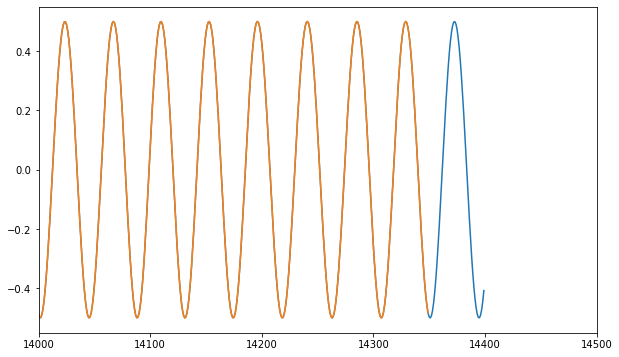

In [218]:
# Sanity check
# Should be all equal and true if noise_spread = 0
lag = 50
a = data
plt.xlim(14000,14500)
plt.plot(a["sync"][0])
plt.plot(a["sync"][1][lag:])

print(np.equal(a["gaze"][0],a["sync"][0]))
print(np.equal(a["sync"][0][:-lag],a["sync"][1][lag:]))

### IBI data

In [62]:
# Generate rpeaks based on rpeaks_idx
def rpeaks_from_rpeaks_idx(rpeaks_idx, length):
    """Generates binary r-peaks pd.Series based on r-peak indices

    Args:
        rpeaks_idx (array): array of r-peaks indices
        length (int): length of time series

    Returns:
        rpeaks: pd.Series, 0 = no event & 1 = r-peak
    """
    zero_ts = np.zeros(length)
    rpeaks = pd.Series(
        zero_ts, 
        name="ECG_R_Peaks", 
        dtype="int64")
    j = 0
    for i,_ in enumerate(rpeaks):
        if i == rpeaks_idx[j]:
            rpeaks[i] = 1
            j = j+1
        if j == len(rpeaks_idx):
            break
    return rpeaks

In [63]:
rpeaks["sync"] = [
    rpeaks_from_rpeaks_idx(rpeaks_idx["sync"][i],length) 
    for i in participants
]

In [64]:
# Functions for preprocessing

# Calculate IBI data as time series
def get_ibi_timeseries(rpeaks, ibi, start, begin_at_0):
    """Generates pd.Series based on binary r-peak time series, where y = 1 is changed to the corresponding IBI and y = 0 remains unchanged.\n
        Used for the tachogram and the basis for linear interpolation of IBI data. 

    Args:
        rpeaks (pd.Series): binary pd.Series
        ibi (array): IBI data
        start (int): second IBI value (ibi[1]) as the first IBI value does not represent a whole IBI
        begin_at_0 (bool): add zeros to start and and to make the pd.Series as long as the original sequence

    Returns:
        ibi_ts (pd.Series): IBI time series used for tachogram and the basis for linear interpolation of IBI data.
    """
    ibi_ts = rpeaks[start:]
    ibi_ts = np.array(ibi_ts)
    j = 0
    for i in range(len(ibi_ts)):
        if ibi_ts[i] == 1:
            ibi_ts[i] = ibi[j]
            j = j+1
    ibi_ts = pd.Series(ibi_ts)
    # add zeros for true lenght of the time series
    if begin_at_0 == "True":
        intro = pd.Series(np.zeros(start))
        ibi_ts = pd.concat([intro, ibi_ts], ignore_index=True)
    return ibi_ts

# Interpolate IBIs
def get_ibi_timeseries_interpolated(ibi_ts):
    """Generates linear interpolated IBI data with the same number of time steps as the input data.

    Args:
        ibi_ts (pd.Series): pd.Series with for tachograms

    Returns:
        ibi_ts_ip: linear interpolated IBI data
    """
    ibi_ts_ip = ibi_ts.replace(0, np.nan, inplace=False)
    ibi_ts_ip = ibi_ts_ip.interpolate(
        method='linear',
        axis=0,
        limit=None,
        inplace=False)
    return ibi_ts_ip

# Resampling at 1 Hz with rolling windows
def get_ibi_timeseries_interpolated_window(ibi_ts_ip):
    """Resampling interpolated time series at 1 Hz based on rolling window average.

    Args:
        ibi_ts_ip (pd.Series): linear interpolated IBI data with the same number of time steps as rpeaks

    Returns:
        ibi_ts_ip_win (pd.Series):  time series at 1 Hz based on rolling window average
    """
    ibi_ts_ip_win = ibi_ts_ip.rolling(sampling_rate, center=True).mean()
    ibi_ts_ip_win = ibi_ts_ip_win.iloc[::sampling_rate]
    return ibi_ts_ip_win


In [65]:
# Get data
ibi = {}
ibi_ts = {}
ibi_ts_ip = {}
ibi_ts_ip_1hz = {}
ibi_ts_ip_win = {}

conditions=["gaze", "sync"]

for con in conditions:
    # Calculate IBI
    ibi[con] = [
        [
            rpeaks_idx[con][i][s]-rpeaks_idx[con][i][s-1]
            for s in range(len((rpeaks_idx[con][i])))
            if s > 0
        ]
        for i in participants
    ]

    # Get IBI data as time series
    ibi_ts[con] = [
        get_ibi_timeseries(
            rpeaks[con][i],
            ibi[con][i],
            rpeaks_idx[con][i][1],
            begin_at_0="True")
        for i in participants
    ]

    # Interpolate IBI
    ibi_ts_ip[con] = [
        get_ibi_timeseries_interpolated(ibi_ts[con][i])
        for i in participants
    ]

    # Resampling interpolated IBI at 1 Hz
    ibi_ts_ip_1hz[con] = [
        ibi_ts_ip[con][i][::sampling_rate]
        for i in participants
    ]

    # Resampling at 1 Hz with rolling windows
    ibi_ts_ip_win[con] = [
        get_ibi_timeseries_interpolated_window(ibi_ts_ip[con][i])
        for i in participants
    ]

(0.0, 40.0)

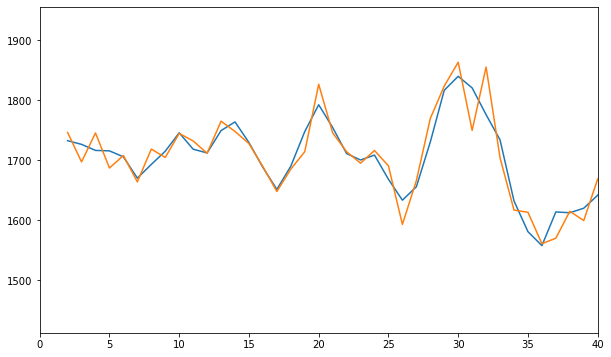

In [66]:
plt.plot(np.array(ibi_ts_ip_1hz["gaze"][0]))
plt.plot(np.array(ibi_ts_ip_1hz["sync"][1]))
plt.xlim(0,40)

## Plot data

In [67]:
# SYNC
# Plot data & sanity check
plt.plot(data_fin["sync"][0])
plt.plot(data_fin["sync"][1])
plt.xlim(0,2000)
np.equal(data_fin["gaze"][3][:-lag], data_fin["sync"][2])


KeyError: 'sync'

In [ ]:
corr = np.corrcoef(data_fin["sync"][0],data_fin["sync"][1])[0,1]
corr

0.3798281611939498

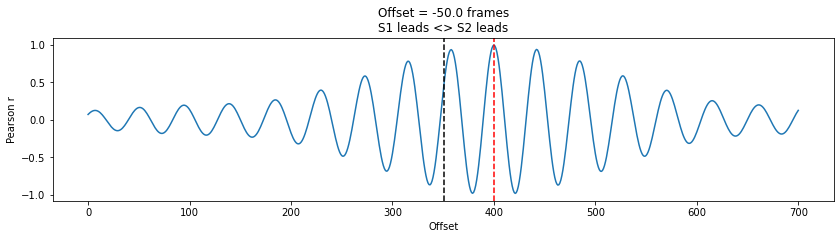

In [ ]:
# Modified from:
# https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

d1 = pd.Series(data_fin["sync"][0])
d2 = pd.Series(data_fin["sync"][1])
seconds = 7
sampling_rate = 50
rs = [
    crosscorr(d1,d2, lag) 
    for lag in range(
        -int(seconds*sampling_rate),
        int(seconds*sampling_rate+1))
    ]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads', xlabel='Offset',ylabel='Pearson r');